In [1]:
# asarray array 차이
# np.eye 원핫인코딩 원리
# watch가 뭔지
# persistnet = True?

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')

In [3]:
# !cp ../gdrive/MyDrive/tmp/pascal_20_detection.zip /content
# !unzip pascal_20_detection.zip
# !unzip pascal_20_detection.zip
# !cp ../gdrive/MyDrive/tmp/model.yml /content

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import math
import numpy as np
import os
import cv2
import xmltodict

In [5]:
cv2.__version__

'4.5.5'

In [6]:
def get_Classes_inImage(xml_file_list):
  Classes_inDataSet = set([])

  for xml_file_path in xml_file_list:
    f = open(xml_file_path)
    xml_file = xmltodict.parse(f.read())

    xml_file_list = []
    if str(type(xml_file['annotation']['object'])) == "<class 'dict'>":
      xml_file_list.append(xml_file['annotation']['object'])
    else:
      xml_file_list = xml_file['annotation']['object']
    
    for obj in xml_file_list:
      Classes_inDataSet.add(obj['name'].lower()) # 들어있는 객체 종류를 알아낸다
      
    f.close()

  Classes_inDataSet = list(Classes_inDataSet)
  Classes_inDataSet.sort() # 정렬

  return Classes_inDataSet

In [7]:
class EdgeBoxes():
  def __init__(self, model_path):
    self.model = model_path
    try:
        self.edge_detection = cv2.ximgproc.createStructuredEdgeDetection(self.model)
    except:
        print('Invalid model path or the model file is corrupt.')
      
  def __call__(self, image_array, maxBoxes=2000):
    self.im = image_array
    # self.rgb_im = cv2.cvtCol
    edges = self.edge_detection.detectEdges(np.float32(self.im))

    orimap = self.edge_detection.computeOrientation(edges)
    edges = self.edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(maxBoxes)
    return edge_boxes.getBoundingBoxes(edges, orimap)

In [8]:
def get_Ground_Truth_Box_fromImage(file_path):
  f = open(file_path)
  xml_file = xmltodict.parse(f.read())
  Ground_Truth_Box_list = []
  classes = []

  xml_file_list = []
  if str(type(xml_file['annotation']['object'])) == "<class 'dict'>":
    xml_file_list.append(xml_file['annotation']['object'])
  else:
    xml_file_list = xml_file['annotation']['object']

  for obj in xml_file_list:
    # 박스 좌표(왼쪽 위, 오른쪽 아래) 얻기
    x_min = float(obj['bndbox']['xmin']) 
    y_min = float(obj['bndbox']['ymin'])
    x_max = float(obj['bndbox']['xmax']) 
    y_max = float(obj['bndbox']['ymax'])
    Ground_Truth_Box = [x_min, y_min, x_max, y_max]
    Ground_Truth_Box_list.append(Ground_Truth_Box)

    classEncoding = obj['name'].lower()

    cls_index = classIndata.index(classEncoding) # 클래스가 Classes_inDataSet 내에서 어떤 인덱스 번호를 갖고 있는가?
    cls_onehot_inImage = np.eye(len(classIndata))[cls_index] # (n,21) 크기의 리스트 받음. 여기서 n은 한 이미지 내에 있는 객체 숫자
    classes.append(np.asarray(cls_onehot_inImage))

  return (np.asarray(Ground_Truth_Box_list), np.asarray(classes))

In [9]:
class dataloader(Sequence):
  def __init__(self, image, anns, classIndata, batch_size):
    self.image = image
    self.anns = anns
    self.batch_size = batch_size

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)
  def __getitem__(self, idx):
    batch_image = self.image[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_anns = self.anns[idx * self.batch_size:(idx + 1) * self.batch_size]
    
    anns_return = []
    class_return = []
    for ann in batch_anns:
      (a, c) = get_Ground_Truth_Box_fromImage(ann)
      anns_return.append(a)
      class_return.append(c)

    edgeboxes = EdgeBoxes('edge_detect.yml')

    batch_return = []
    rois = []
    for image_path in batch_image:
      converted_image = np.asarray(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
      batch_return.append(converted_image)
      edgebox = edgeboxes(converted_image)
      boxes, scores = edgebox
      rois.append(boxes)

    return (np.asarray(batch_return), np.asarray(anns_return), np.asarray(class_return), np.asarray(rois))

In [10]:
image_folder = 'C:/godspell/' + 'pascal_20_detection/imgs'
anns_folder = 'C:/godspell/' + 'pascal_20_detection/anns'
image_file_list = [image_folder + '/' + x for x in sorted(os.listdir(image_folder))]
anns_file_list = [anns_folder + '/' + x for x in sorted(os.listdir(anns_folder))]

# classIndata = get_Classes_inImage(anns_file_list)
classIndata = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [11]:
train_dataloader = dataloader(image_file_list, anns_file_list, classIndata, 1)
train_dataloader.__getitem__(2)[3].shape

error: Unknown C++ exception from OpenCV code

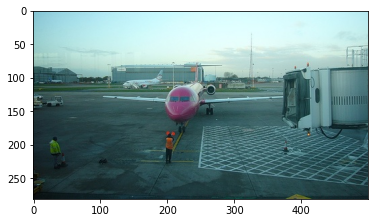

In [225]:
import matplotlib.pyplot as plt
plt.imshow(train_dataloader.__getitem__(1)[0][0])

In [84]:
edgeboxes = EdgeBoxes('../edge_detect.yml')

converted_image = cv2.cvtColor(cv2.imread(image_file_list[10]), cv2.COLOR_BGR2RGB)
edgebox = edgeboxes(converted_image)
print(type(edgebox))
# boxes, scores = edgebox

Invalid model path or the model file is corrupt.
<class 'NoneType'>


In [140]:
# model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

In [87]:
model = tf.keras.models.Sequential()
for layer in vgg.layers[:-1]:
  model.add(layer)

In [185]:
file_path = anns_file_list[3]

f = open(file_path)
xml_file = xmltodict.parse(f.read())
Ground_Truth_Box_list = [] 

xml_file['annotation']['object']
aa = []
aa.append(xml_file['annotation']['object'])
aa

[{'bndbox': {'xmax': '344', 'xmin': '156', 'ymax': '279', 'ymin': '89'},
  'difficult': '0',
  'name': 'tvmonitor',
  'pose': 'Frontal',
  'truncated': '0'}]

In [191]:
file_path = anns_file_list[2]

f = open(file_path)
xml_file = xmltodict.parse(f.read())
Ground_Truth_Box_list = []

xml_file_list = []
if type(xml_file) == 'dict':
  xml_file_list.append(xml_file)
else:
  xml_file_list = xml_file

xml_file['annotation']['object']

[{'bndbox': {'xmax': '499', 'xmin': '9', 'ymax': '263', 'ymin': '107'},
  'difficult': '0',
  'name': 'aeroplane',
  'pose': 'Unspecified',
  'truncated': '0'},
 {'bndbox': {'xmax': '482', 'xmin': '421', 'ymax': '226', 'ymin': '200'},
  'difficult': '0',
  'name': 'aeroplane',
  'pose': 'Left',
  'truncated': '0'},
 {'bndbox': {'xmax': '411', 'xmin': '325', 'ymax': '223', 'ymin': '188'},
  'difficult': '0',
  'name': 'aeroplane',
  'pose': 'Left',
  'truncated': '1'}]

In [51]:
np.eye(10)[9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])